# RNN Based Models
Bidirectional is better

The output of the Bidirectional RNN will be, by default, the concatenation of the forward layer output and the backward layer output.

In [1]:
import os
import pathlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
from models import *
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from python_speech_features import mfcc
import librosa.display
import librosa as lr
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from input_pipeline import _DATA_DIR_, _BINARIES_DIR_, _UNKNOWN_CLASS_, _SILENCE_CLASS_, _MODELS_DIR_, _TASKS_
from input_pipeline import *
from metrics import *
from custom_layers import MFCC, LogMelSpectrogram, Spectrogram
from utils import *

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2021-08-21 03:41:59.472634: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
_SMOKE_SIZE_ = -1

In [3]:
current_task = _TASKS_[0]
print(current_task)
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(current_task)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task)



print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

10kws+U+S
Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

Auxiliary keywords:  ['cat', 'zero', 'happy', 'eight', 'five', 'nine', 'marvin', 'follow', 'wow', 'forward', 'backward', 'sheila', 'house', 'visual', 'bed', 'bird', 'six', 'dog', 'four', 'two', 'tree', 'seven', 'three', 'one', 'learn']

Output Classes:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'filler', 'silence']
Samples in Training Set: 98449
Samples in Test Set: 10378
Samples in Validation Set: 11424


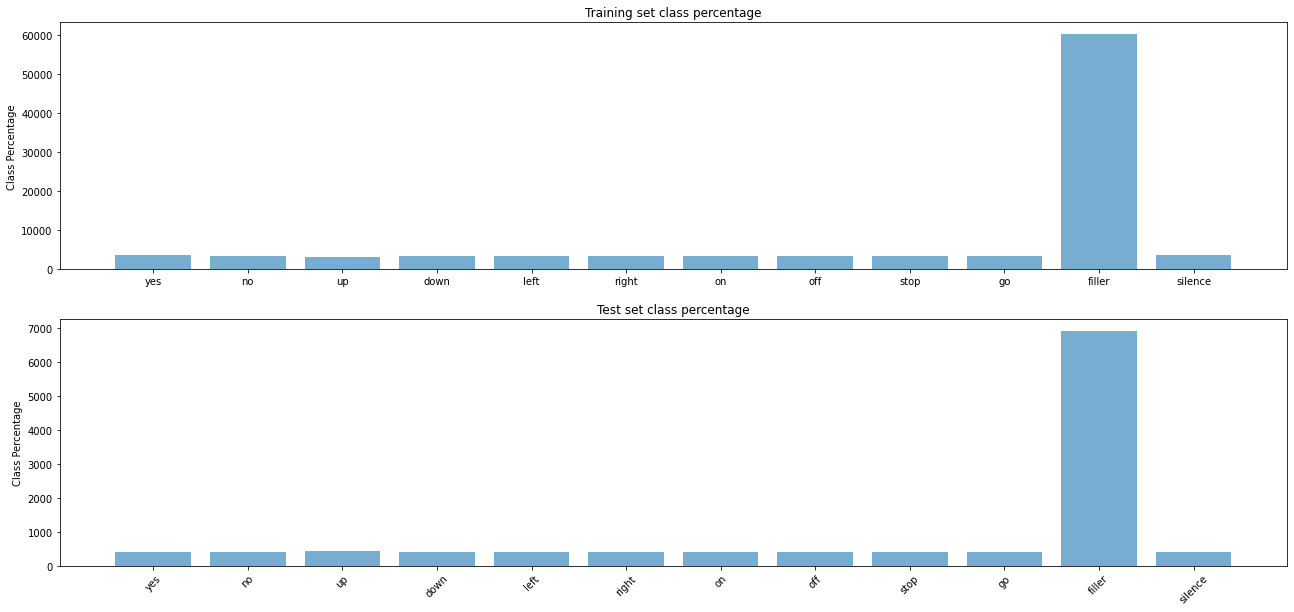

In [7]:
visualize_class_balance(y_train,y_valid,output_classes)

In [8]:
batch_size = 128
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size,
                            task=current_task)

2021-08-21 03:42:15.191015: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-21 03:42:15.236460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-21 03:42:15.236808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-21 03:42:15.236846: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-21 03:42:15.239401: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-21 03:42:15.239485: I tensorflow/stream_executor/platf

Train steps: 770
Validations steps: 90
Example of dataset element:
(<tf.Tensor: shape=(128, 16000), dtype=float32, numpy=
array([[ 0.00670831, -0.00058554, -0.00036658, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04315936,  0.00463019,  0.02497448, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00108522,  0.00035046,  0.00068114, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.03463615,
         0.03593059,  0.01325285],
       [ 0.        ,  0.        ,  0.        , ...,  0.00012825,
         0.00107307, -0.00171903],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>, <tf.Tensor: shape=(128,), dtype=int64, numpy=
array([10,  9,  1, 10, 10, 10, 10, 10, 10,  3,  2, 10,  2,  8, 10,  3,  8,
       10, 10, 11,  5,  0, 10, 10,  9, 10,  8, 10,  4,  4, 10, 10, 10, 10,
        9, 10, 10, 10, 10,  4, 10,  0, 10, 10, 10, 1

## Simple RNN

In [7]:
def simple_rnn(ds, 
               output_classes, 
               n_mfcc, 
               mfcc_deltas, 
               fft_size=512, 
               win_size=400, 
               hop_size=160, 
               n_filters=40):
    
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)

    X_input = tf.keras.Input(input_shape)
    X = MFCC(sample_rate = 16000, 
             fft_size=fft_size, 
             win_size=win_size, 
             hop_size=hop_size, 
             n_filters=n_filters, 
             n_cepstral=n_mfcc,
            return_deltas=mfcc_deltas)(X_input)
    X = layers.BatchNormalization(axis=-1)(X)
    
    X = layers.Lambda(lambda w: tf.keras.backend.squeeze(w, -1))(X)
    X = layers.Bidirectional(layers.GRU(units=128, 
                                        kernel_regularizer=tf.keras.regularizers.l2(l2=0.2),
                                       recurrent_regularizer = tf.keras.regularizers.l2(l2=0.3)))(X)
    X = layers.Dropout(0.5)(X)
    X = layers.Dense(len(output_classes))(X)

    model = tf.keras.Model(inputs=X_input, outputs=X, name="SimpleRNN")
    return model

In [11]:
model_simple_rnn = simple_rnn(train_dataset, output_classes, n_mfcc=40, mfcc_deltas=False)
model_simple_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Input shape: (16000,)


In [9]:
model_simple_rnn.summary()

Model: "SimpleRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc (MFCC)                  (None, 98, 40, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 40, 1)         4         
_________________________________________________________________
lambda (Lambda)              (None, 98, 40)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               130560    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                30

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
            verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_simple_rnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)


Epoch 1/30


2021-08-21 03:07:26.958832: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-21 03:07:27.046672: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-21 03:07:27.299747: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-21 03:07:27.301082: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-21 03:07:27.597939: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


770/770 [==============================] - ETA: 0s - loss: 43.6202 - accuracy: 0.5927

2021-08-21 03:08:27.275508: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


770/770 [==============================] - 72s 89ms/step - loss: 43.6202 - accuracy: 0.5927 - val_loss: 12.4338 - val_accuracy: 0.6065
Epoch 2/30
  6/770 [..............................] - ETA: 18s - loss: 12.3284 - accuracy: 0.6159

2021-08-21 03:08:36.394036: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


770/770 [==============================] - 18s 23ms/step - loss: 5.5970 - accuracy: 0.6298 - val_loss: 2.4753 - val_accuracy: 0.6062
Epoch 3/30
770/770 [==============================] - 17s 22ms/step - loss: 1.8247 - accuracy: 0.6394 - val_loss: 1.6591 - val_accuracy: 0.6059
Epoch 4/30
770/770 [==============================] - 17s 22ms/step - loss: 1.5324 - accuracy: 0.6460 - val_loss: 1.6033 - val_accuracy: 0.6061
Epoch 5/30
580/770 [=====================>........] - ETA: 3s - loss: 1.5075 - accuracy: 0.6475

KeyboardInterrupt: 

In [33]:
#save model
model_simple_rnn.save(_MODELS_DIR_/current_task/(model_simple_rnn.name+'.h5'))

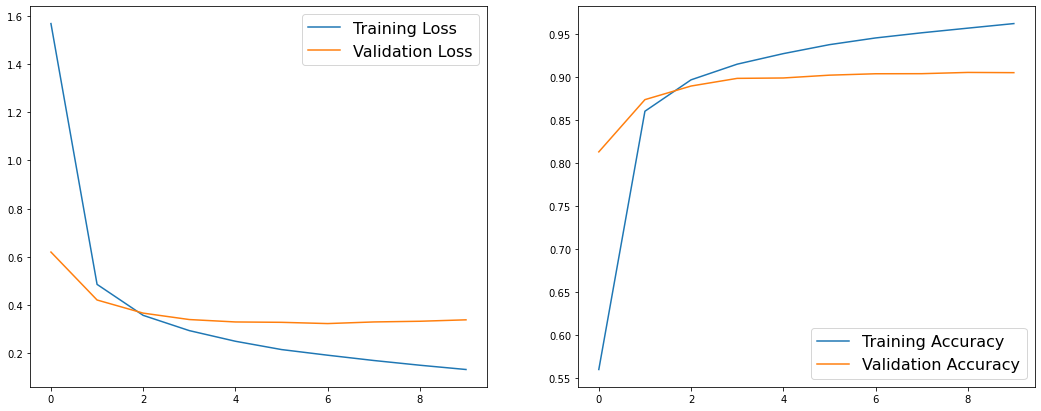

In [18]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

In [22]:
y_scores = model_simple_rnn.predict(test_dataset)
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

Test set accuracy: 95.061%


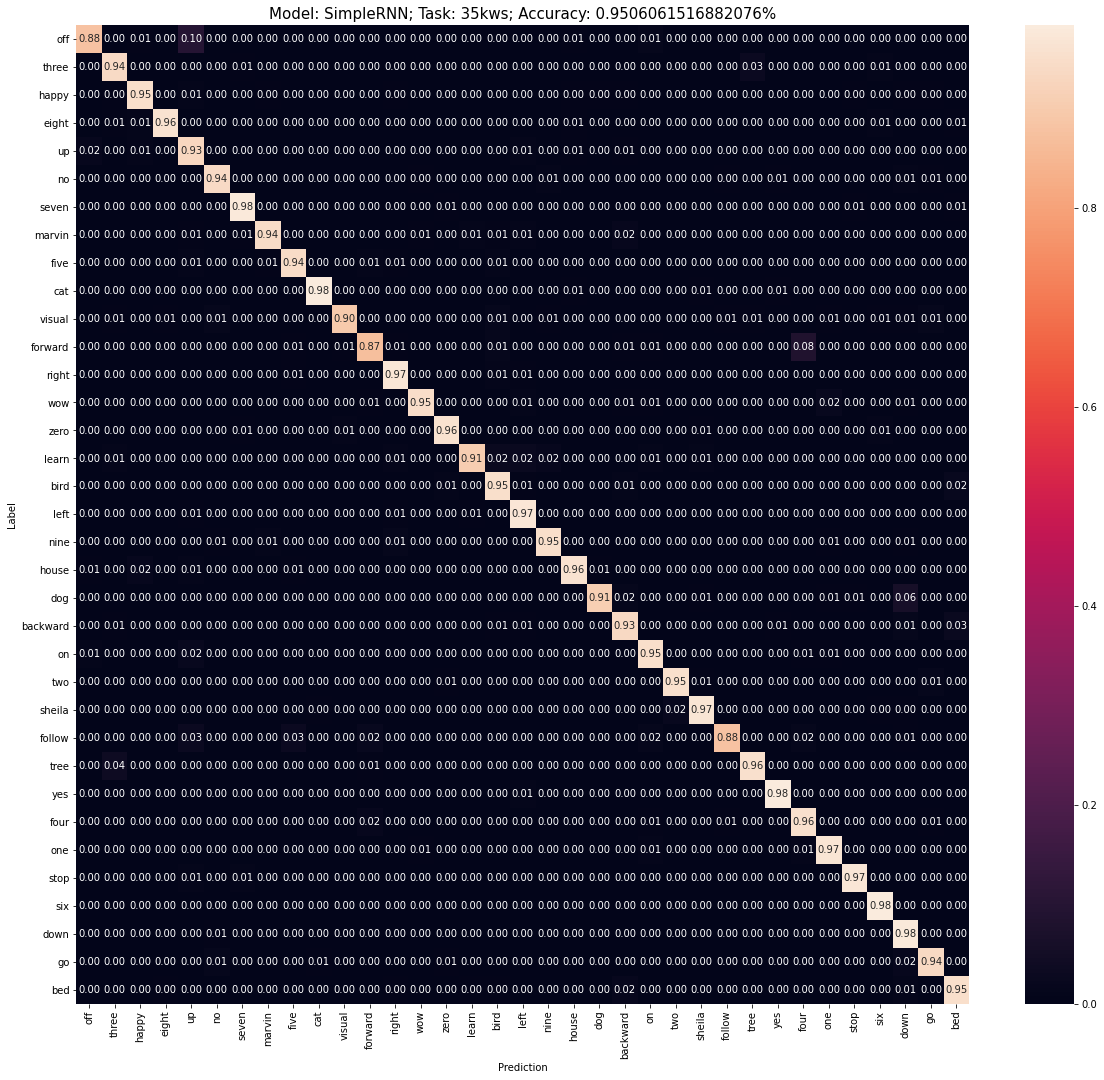

In [31]:
# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f"Model: {model_simple_rnn.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model_simple_rnn.name}.png', dpi=300)
plt.show()

## CNN + RNN

In [27]:
def cnn_rnn(ds, 
               output_classes, 
               n_mfcc, 
               mfcc_deltas, 
               fft_size=512, 
               win_size=400, 
               hop_size=160, 
               n_filters=40):
    
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)

    X_input = tf.keras.Input(input_shape)
    X = MFCC(sample_rate = 16000, 
             fft_size=fft_size, 
             win_size=win_size, 
             hop_size=hop_size, 
             n_filters=n_filters, 
             n_cepstral=n_mfcc,
            return_deltas=mfcc_deltas)(X_input)
    X = layers.BatchNormalization(axis=-1)(X)
    
    X = layers.Conv2D(64, (20,1))(X)
    X = layers.BatchNormalization(axis =-1)(X)
    X = layers.Activation('relu')(X)
    
    X = layers.Conv2D(1, (10,1))(X)
    X = layers.BatchNormalization(axis =-1)(X)
    X = layers.Activation('relu')(X)

    
    X = layers.Lambda(lambda w: tf.keras.backend.squeeze(w, -1))(X)
    X = layers.Bidirectional(layers.GRU(units=128))(X)
    X = layers.Dense(len(output_classes))(X)

    model = tf.keras.Model(inputs=X_input, outputs=X, name="SimpleRNN")
    return model

In [28]:
model_cnn_rnn = cnn_rnn(train_dataset, output_classes, n_mfcc=40, mfcc_deltas=False)
model_cnn_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_cnn_rnn.summary()

Input shape: (16000,)
Model: "SimpleRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc_2 (MFCC)                (None, 98, 40, 1)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 98, 40, 1)         4         
_________________________________________________________________
conv1 (Conv2D)               (None, 79, 40, 64)        1344      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 79, 40, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 79, 40, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None,

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
            verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_cnn_rnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)


Epoch 1/30
741/741 [==============================] - 42s 52ms/step - loss: 1.8095 - accuracy: 0.4870 - val_loss: 0.9009 - val_accuracy: 0.7335
Epoch 2/30
257/741 [=========>....................] - ETA: 24s - loss: 0.8238 - accuracy: 0.7598

KeyboardInterrupt: 

## Attention based RNN

In [260]:
w = generate_train_sample(X_train[0])
w = tf.expand_dims(w,0)
w = tf.concat([w,w], 0)
w

<tf.Tensor: shape=(2, 16000), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , ..., 0.00043109, 0.00045743,
        0.00094112],
       [0.        , 0.        , 0.        , ..., 0.00043109, 0.00045743,
        0.00094112]], dtype=float32)>

In [29]:
def simple_attention_rnn(ds):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)

    X_input = tf.keras.Input(input_shape)
    X = MFCC(sample_rate = 16000, 
                 fft_size=512, 
                 win_size=400, 
                 hop_size=160, 
                 n_filters=40, 
                 n_cepstral=40,
                return_deltas=False)(X_input)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Lambda(lambda x : x[...,-1], name="squeeze_channel_dimension")(X)
    X = layers.Bidirectional(layers.GRU(units=64, return_sequences=True), name="BidirectionalGRU")(X)
    last_out = layers.Lambda(lambda x: x[:,-1,:])(X)
    Q = layers.Dense(128)(last_out)
    Q = layers.Lambda(lambda x: tf.expand_dims(x, 1))(Q)
    weighted_seq, att_ws = layers.Attention()([Q, X], return_attention_scores=True)

    O = layers.Dense(128, activation='relu')(weighted_seq)
    O = layers.Dense(64, activation='relu')(O)
    O = layers.Dense(len(output_classes), name="out_layer")(O)

    att_model = tf.keras.Model(inputs = [X_input], outputs=[O,att_ws])
    return att_model

In [30]:
att_model = simple_attention_rnn(train_dataset)
att_model.summary()

Input shape: (16000,)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
mfcc_4 (MFCC)                   (None, 98, 40, 1)    0           input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 98, 40, 1)    4           mfcc_4[0][0]                     
__________________________________________________________________________________________________
squeeze_channel_dimension (Lamb (None, 98, 40)       0           batch_normalization_6[0][0]      
______________________________________________________________________

In [31]:
# tf.keras.utils.plot_model(att_model)

In [32]:
att_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss={'out_layer':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={'out_layer':'accuracy'},
)

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_accuracy', verbose=1)
history = att_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30


2021-08-21 03:29:15.406946: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5013831680 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


769/770 [============================>.] - ETA: 0s - loss: 0.6394 - out_layer_loss: 0.6394 - out_layer_accuracy: 0.8028

2021-08-21 03:29:30.594258: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5013831680 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


770/770 [==============================] - 19s 22ms/step - loss: 0.6390 - out_layer_loss: 0.6390 - out_layer_accuracy: 0.8029 - val_loss: 0.7511 - val_out_layer_loss: 0.7511 - val_out_layer_accuracy: 0.8534
Epoch 2/30
770/770 [==============================] - 16s 21ms/step - loss: 0.2618 - out_layer_loss: 0.2618 - out_layer_accuracy: 0.9177 - val_loss: 0.6496 - val_out_layer_loss: 0.6496 - val_out_layer_accuracy: 0.8822
Epoch 3/30
770/770 [==============================] - 16s 21ms/step - loss: 0.1938 - out_layer_loss: 0.1938 - out_layer_accuracy: 0.9391 - val_loss: 0.6143 - val_out_layer_loss: 0.6143 - val_out_layer_accuracy: 0.8956
Epoch 4/30
770/770 [==============================] - 16s 21ms/step - loss: 0.1593 - out_layer_loss: 0.1593 - out_layer_accuracy: 0.9500 - val_loss: 0.6478 - val_out_layer_loss: 0.6478 - val_out_layer_accuracy: 0.8944
Epoch 5/30
770/770 [==============================] - 16s 21ms/step - loss: 0.1398 - out_layer_loss: 0.1398 - out_layer_accuracy: 0.9552 - 

In [37]:
y_scores = att_model.predict(test_dataset)
y_scores = y_scores[0][:,0,:]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Test set accuracy: 92.619%


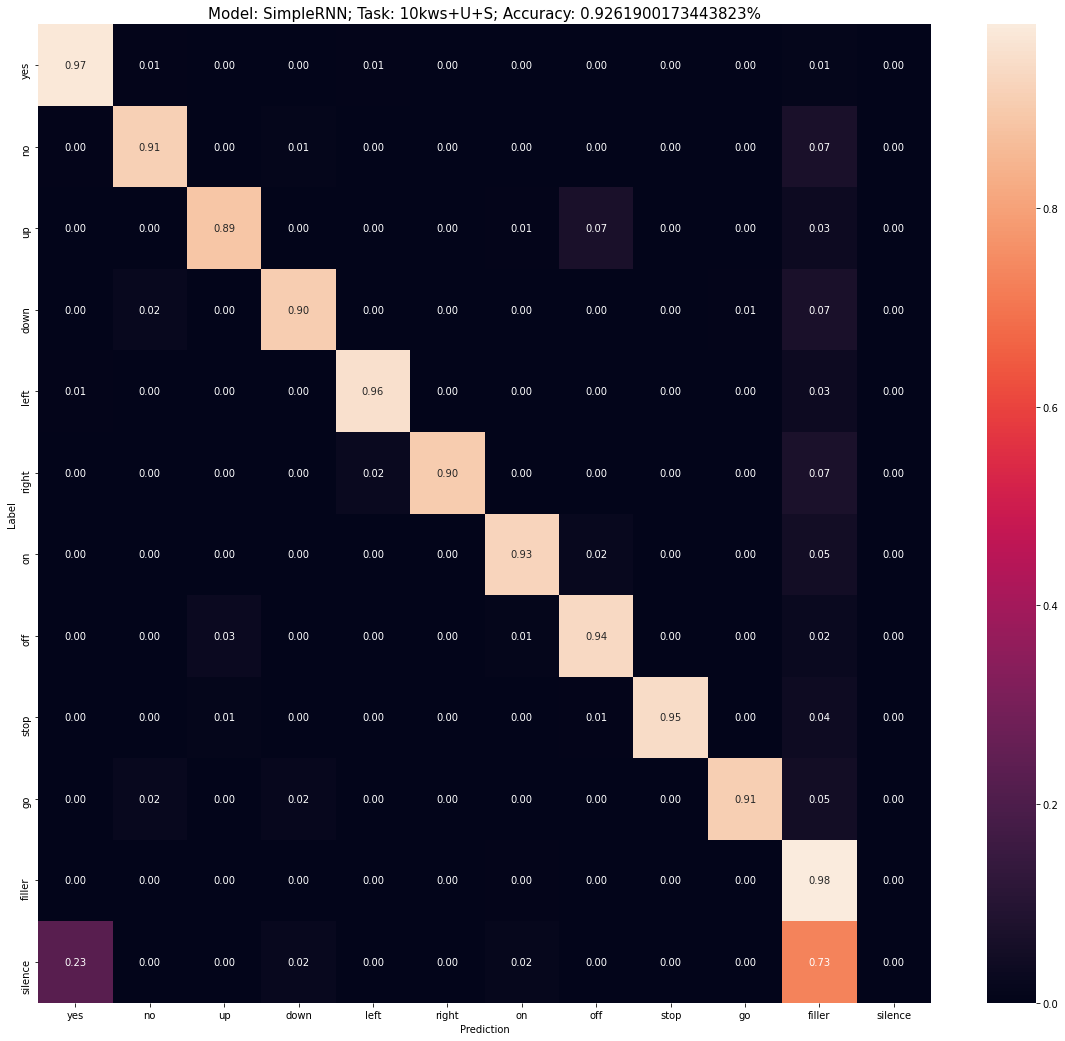

In [38]:
confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f"Model: {model_simple_rnn.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model_simple_rnn.name}.png', dpi=300)
plt.show()

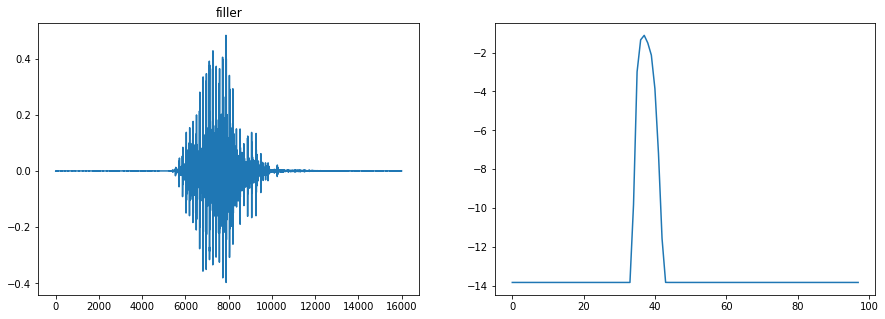

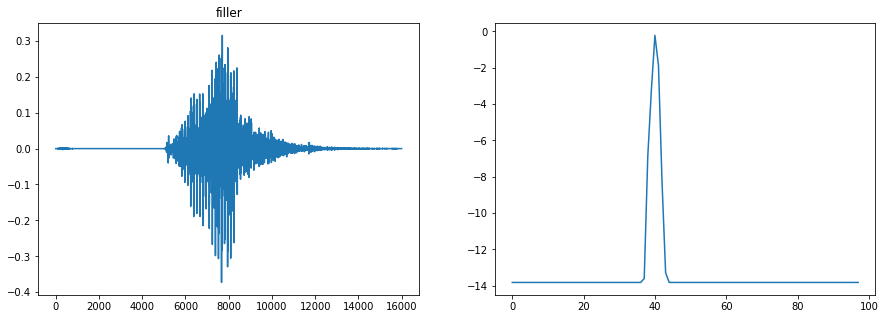

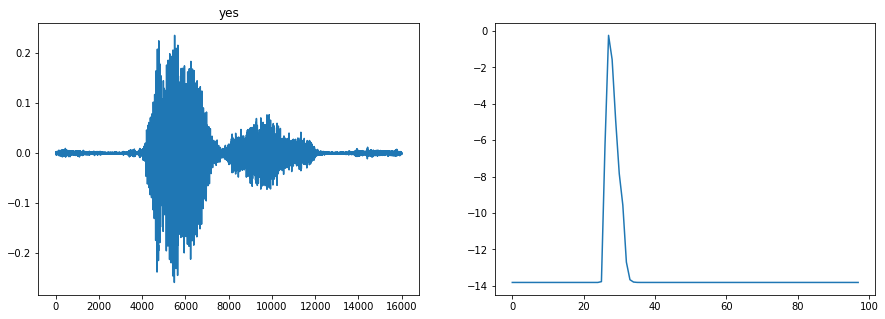

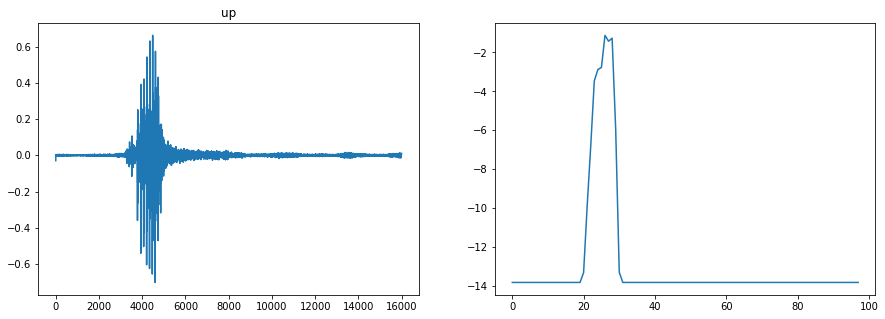

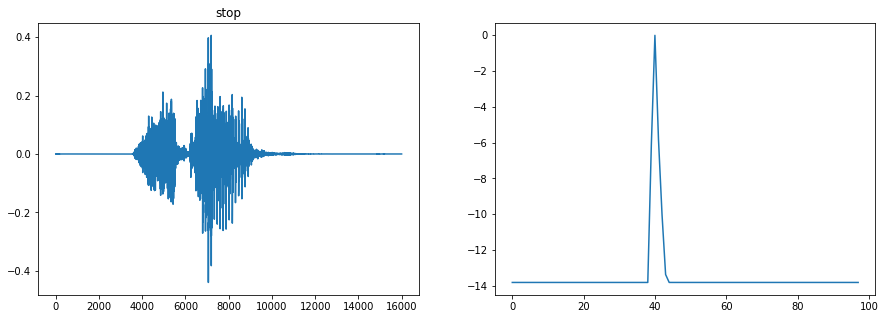

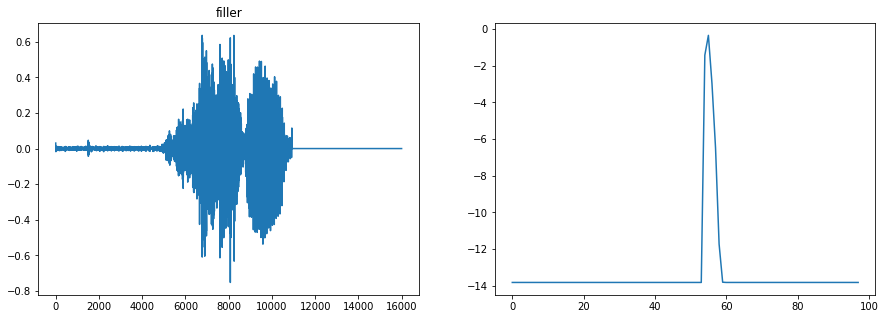

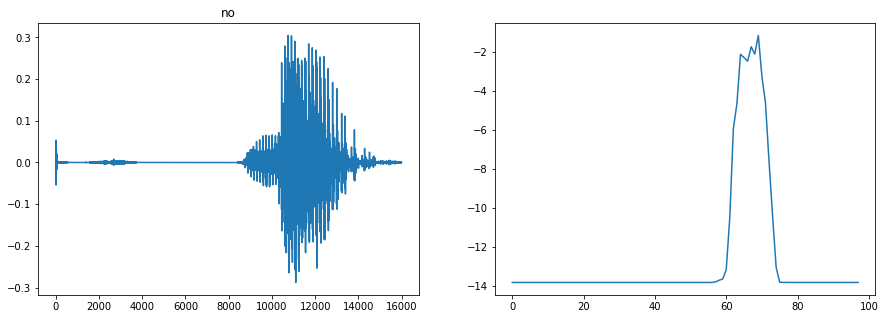

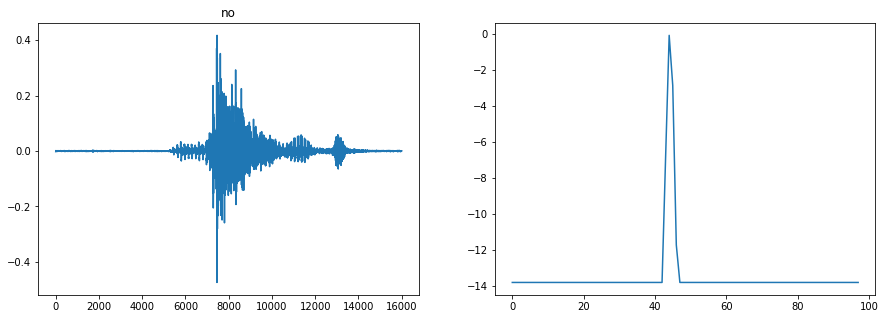

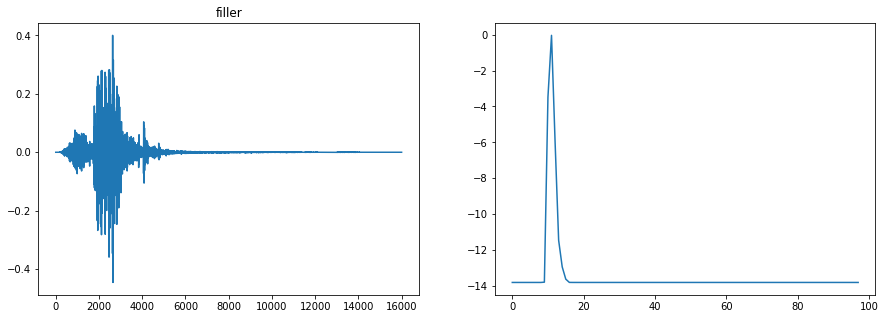

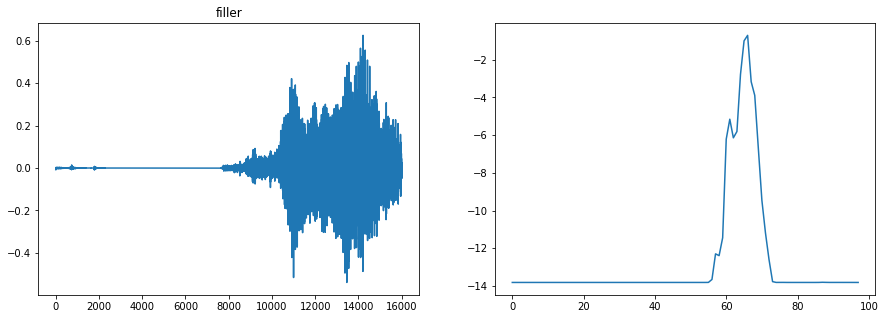

In [19]:
for i in range(10,20):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ex = generate_test_sample(X_test[i])
    ex = tf.expand_dims(ex,0)
    plt.plot(ex[0])
    plt.title(output_classes[y_test[i]])
#     plt.show()
    plt.subplot(1,2,2)
    atts = att_model(ex)[1]
    plt.plot(np.log(atts[0,0,:] + 0.000001))
    
    plt.show()

## Attention model from paper

In [26]:
def attention_rnn_andreade(ds):
    """Neural attention model proposed in de Andreade et al. 2018"""
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)

    X_input = tf.keras.Input(input_shape)
    X =  LogMelSpectrogram(sample_rate = 16000, 
                 fft_size=1024, 
                 win_size=400, 
                 hop_size=160, 
                 n_filters=80)(X_input)
    X = layers.Lambda(lambda x : x[:,:,1:,:], name="remove_energies")(X)
    
    # CNN part
    X = layers.Conv2D(10, (5, 1), activation='relu', padding='same')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Conv2D(1, (5, 1), activation='relu', padding='same')(X)
    X = layers.BatchNormalization()(X)
    
    # Recurrent Part
    X = layers.Lambda(lambda x : x[...,-1], name="squeeze_channel_dimension")(X)
    X = layers.Bidirectional(layers.GRU(units=64, return_sequences=True), name="BidirectionalGRU")(X)
    last_out = layers.Lambda(lambda x: x[:,-1,:])(X)
    
    # Self-Attention
    Q = layers.Dense(128)(last_out)
    Q = layers.Lambda(lambda x: tf.expand_dims(x, 1))(Q)
    weighted_seq, att_ws = layers.Attention()([Q, X], return_attention_scores=True)

    O = layers.Dense(64, activation='relu')(weighted_seq)
    O = layers.Dense(len(output_classes), name="out_layer")(O)

    att_model = tf.keras.Model(inputs = [X_input], outputs=[O,att_ws])
    return att_model

In [27]:
model_att_andreade = attention_rnn_andreade(train_dataset)
model_att_andreade.summary()

Input shape: (16000,)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
log_mel_spectrogram_10 (LogMelS (None, 98, 81, 1)    0           input_5[0][0]                    
__________________________________________________________________________________________________
remove_energies (Lambda)        (None, 98, 80, 1)    0           log_mel_spectrogram_10[0][0]     
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 80, 10)   60          remove_energies[0][0]            
______________________________________________________________________

In [28]:
model_att_andreade.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss={'out_layer':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={'out_layer':'accuracy'},
)

early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_out_layer_accuracy', verbose=1)
history =model_att_andreade.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30


2021-08-21 03:28:33.717290: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5013831680 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


741/770 [===========================>..] - ETA: 1s - loss: 0.6993 - out_layer_loss: 0.6993 - out_layer_accuracy: 0.7989

KeyboardInterrupt: 

In [25]:
y_scores = model_att_andreade.predict(test_dataset)
y_scores = y_scores[0][:,0,:]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

NameError: name 'model_att_andreade' is not defined

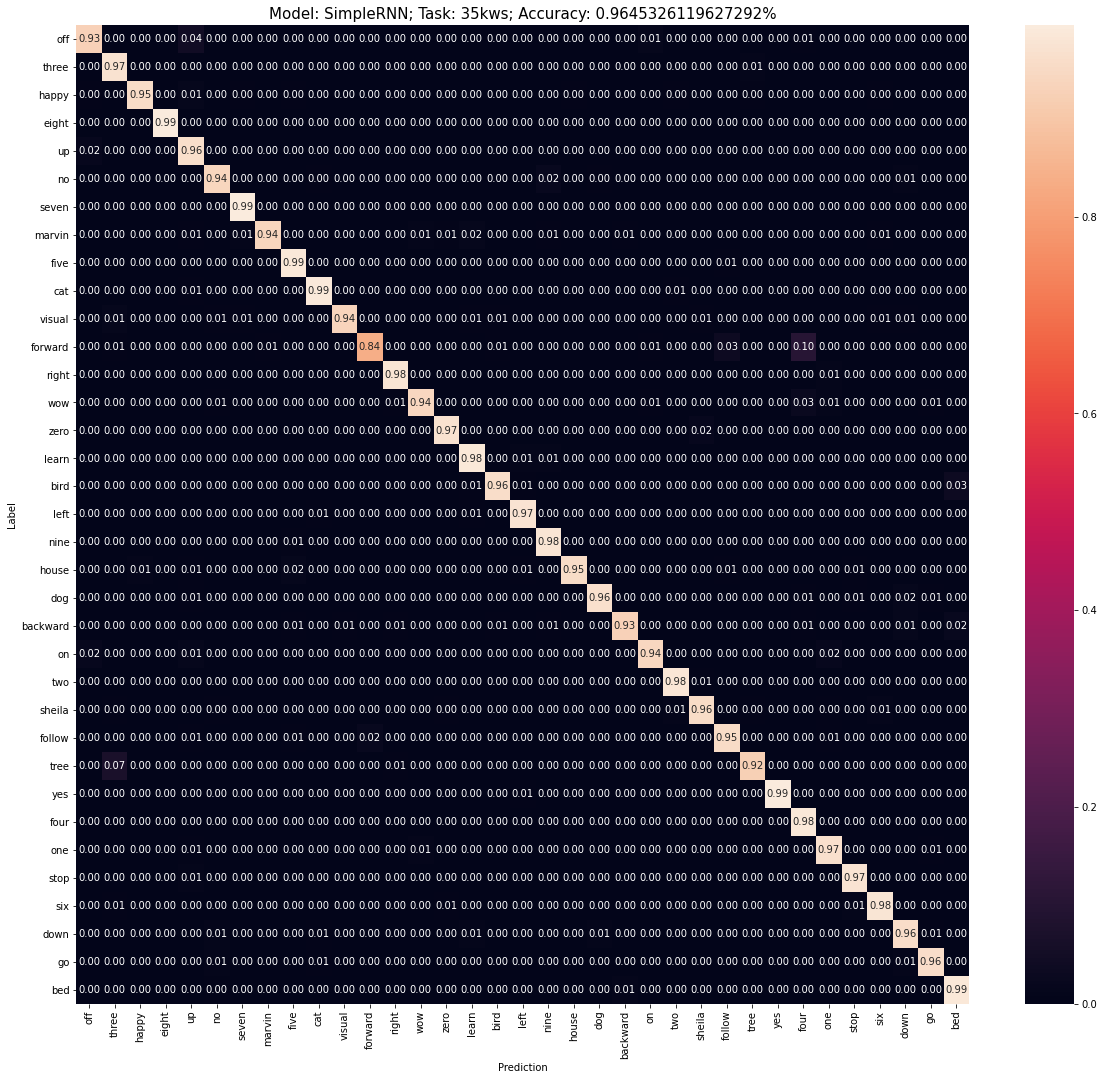

In [444]:
confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f"Model: {model_simple_rnn.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model_simple_rnn.name}.png', dpi=300)
plt.show()

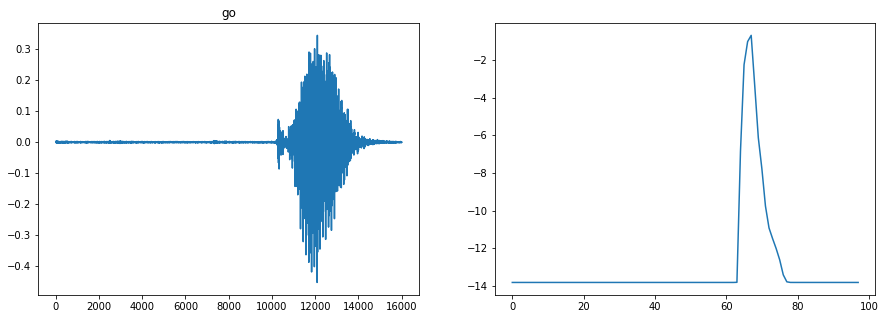

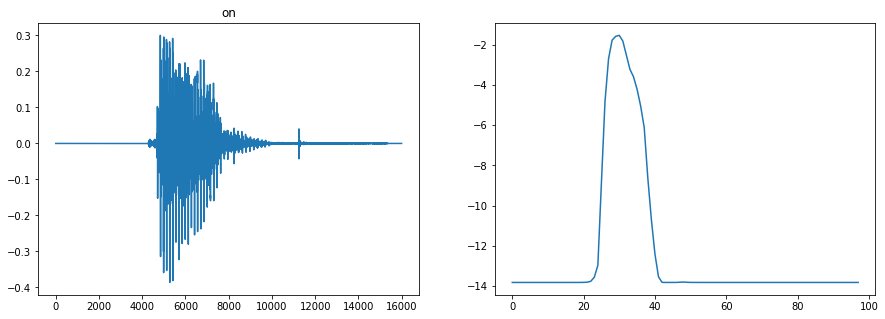

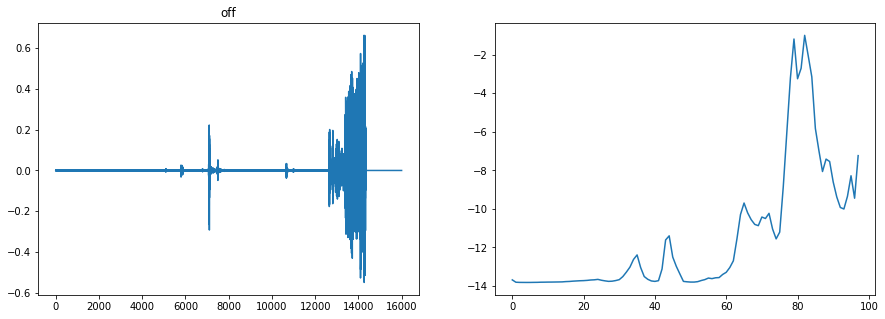

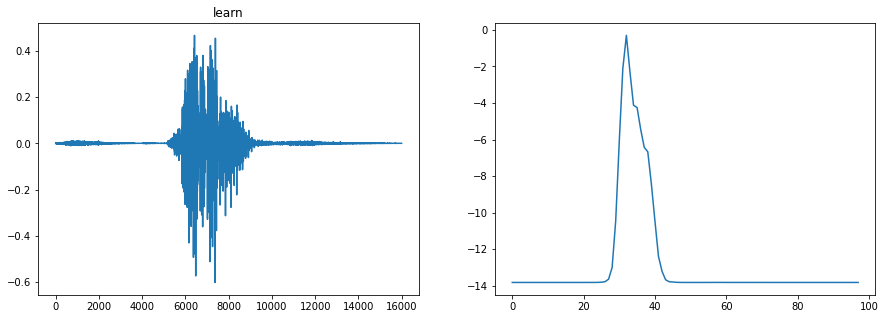

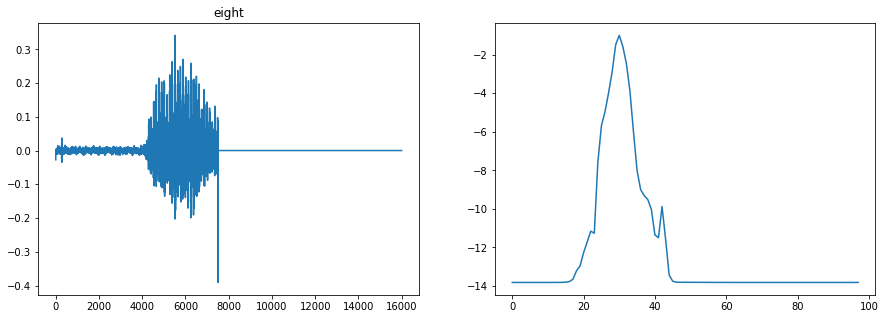

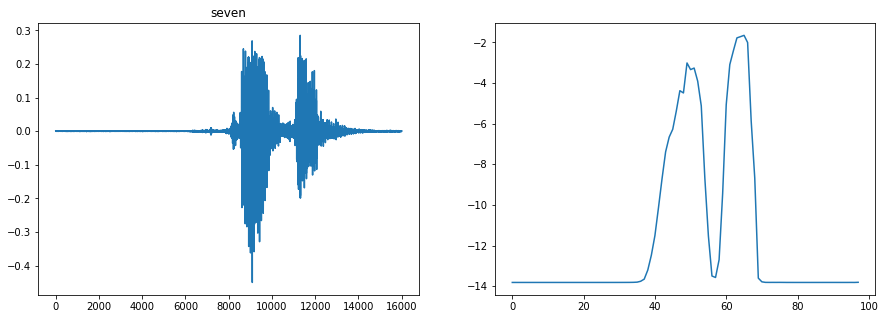

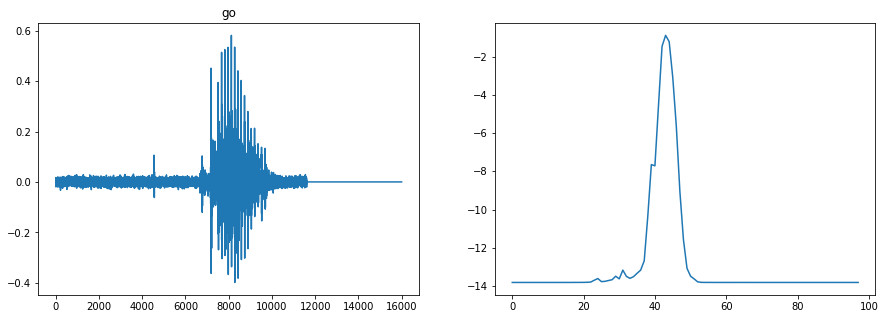

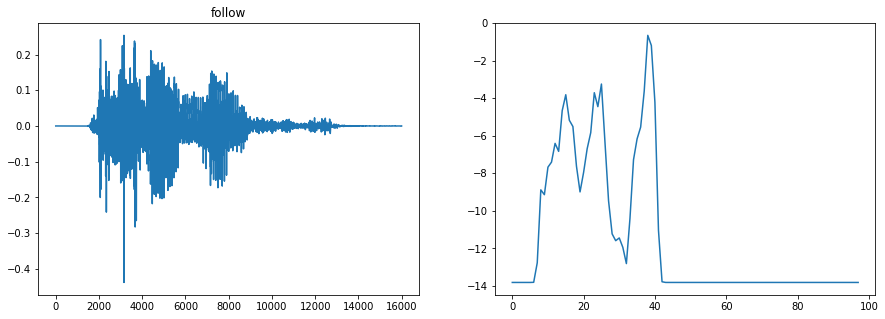

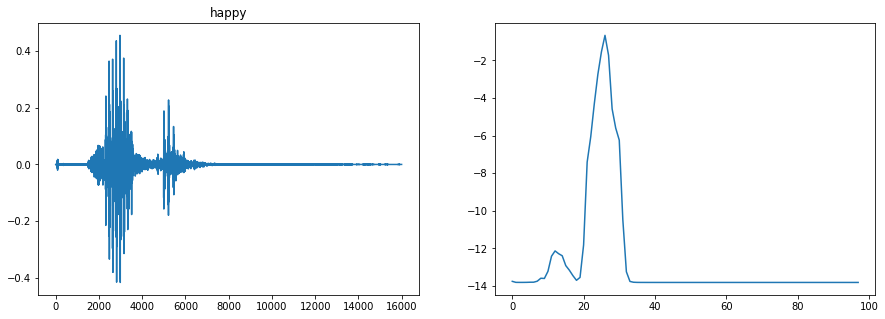

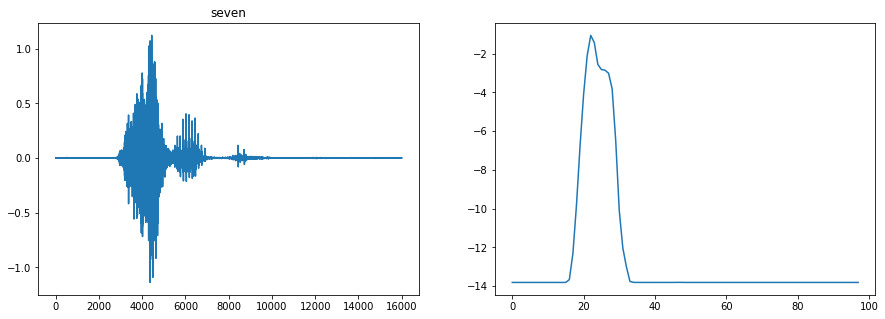

In [445]:
for i in range(10,20):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ex = generate_test_sample(X_test[i])
    ex = tf.expand_dims(ex,0)
    plt.plot(ex[0])
    plt.title(output_classes[y_test[i]])
#     plt.show()
    plt.subplot(1,2,2)
    atts = model_att_andreade(ex)[1]
    plt.plot(np.log(atts[0,0,:] + 0.000001))
    
    plt.show()

## Attention with Multi Head Attention module from Transformers

In [106]:
mod_mha = mha_andreade(train_dataset)

Input shape: (16000,)


In [107]:
mod_mha.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
log_mel_spectrogram_30 (LogMelS (None, 98, 81, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
remove_energies (Lambda)        (None, 98, 80, 1)    0           log_mel_spectrogram_30[0][0]     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 98, 80, 10)   60          remove_energies[0][0]            
______________________________________________________________________________________________

In [109]:
mod_mha.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss={'out_layer':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={'out_layer':'accuracy'},
)

early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_out_layer_accuracy', verbose=1)
history =mod_mha.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30


2021-08-20 18:59:25.502908: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-20 18:59:25.540341: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz
2021-08-20 18:59:26.042541: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-20 18:59:26.956087: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


741/741 [==============================] - 41s 46ms/step - loss: 1.2898 - out_layer_loss: 1.2898 - out_layer_accuracy: 0.6353 - val_loss: 0.4477 - val_out_layer_loss: 0.4477 - val_out_layer_accuracy: 0.8636
Epoch 2/30
741/741 [==============================] - 34s 46ms/step - loss: 0.3813 - out_layer_loss: 0.3813 - out_layer_accuracy: 0.8871 - val_loss: 0.3390 - val_out_layer_loss: 0.3390 - val_out_layer_accuracy: 0.8979
Epoch 3/30
741/741 [==============================] - 34s 46ms/step - loss: 0.2940 - out_layer_loss: 0.2940 - out_layer_accuracy: 0.9116 - val_loss: 0.3008 - val_out_layer_loss: 0.3008 - val_out_layer_accuracy: 0.9096
Epoch 4/30
741/741 [==============================] - 34s 46ms/step - loss: 0.2493 - out_layer_loss: 0.2493 - out_layer_accuracy: 0.9242 - val_loss: 0.2925 - val_out_layer_loss: 0.2925 - val_out_layer_accuracy: 0.9132
Epoch 5/30
741/741 [==============================] - 34s 46ms/step - loss: 0.2183 - out_layer_loss: 0.2183 - out_layer_accuracy: 0.9331 - 

In [110]:
y_scores = mod_mha.predict(test_dataset)
y_scores = y_scores[0][:,0,:]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Test set accuracy: 95.261%


In [111]:
mod_mha.save(_MODELS_DIR_/current_task/("andreade_MHA"+'.h5'))

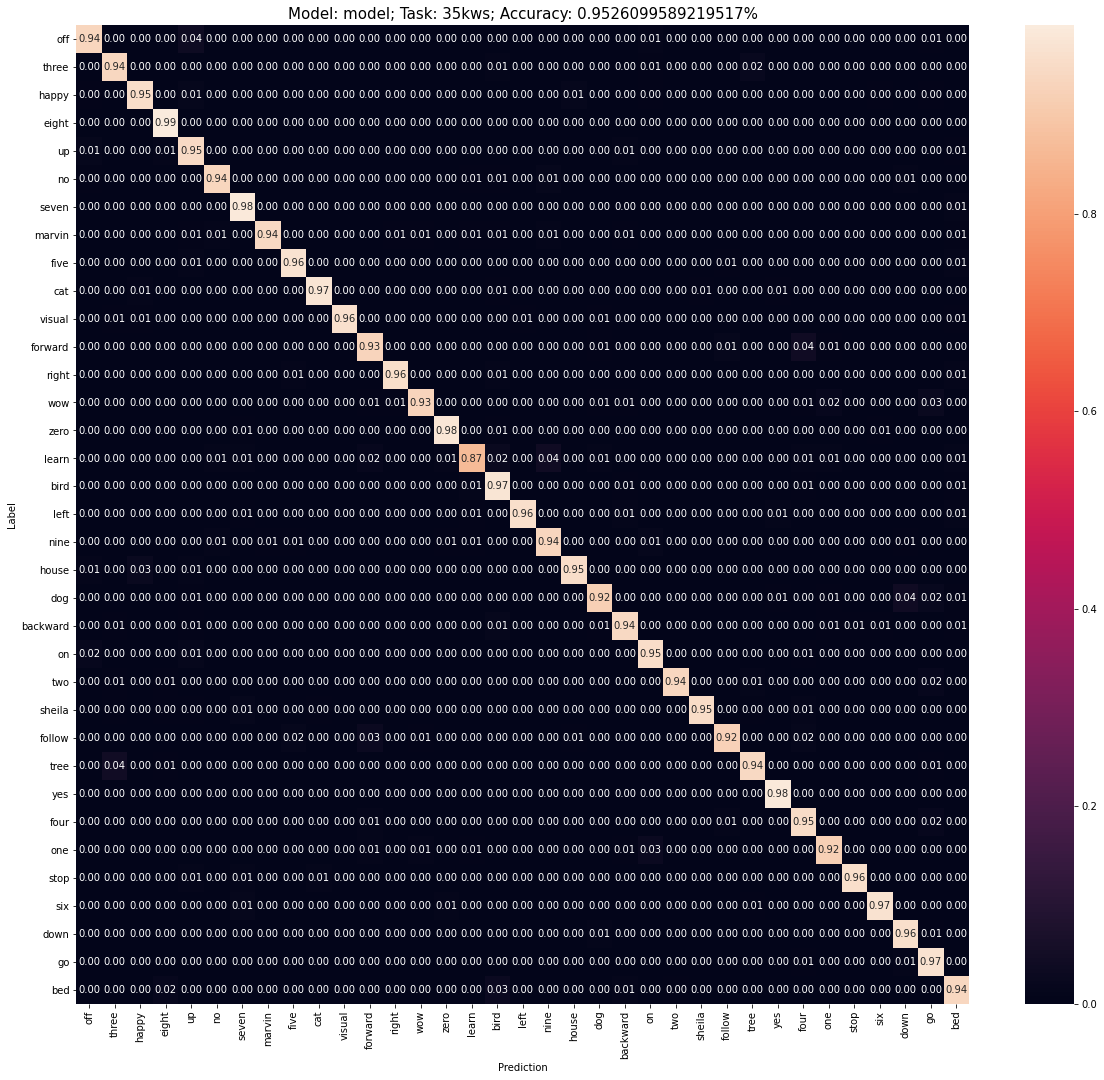

In [113]:
confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f"Model: {mod_mha.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model_simple_rnn.name}.png', dpi=300)
plt.show()

In [160]:
ex = generate_test_sample(X_test[21])
ex = tf.expand_dims(ex,0)
atts = mod_mha(ex)[1]

In [161]:
atts = tf.reshape(atts, (7,98))

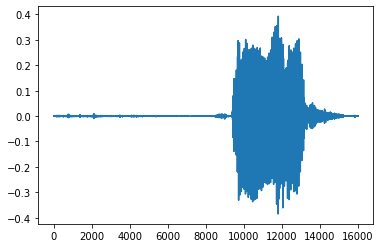

In [162]:
plt.plot(ex[0])

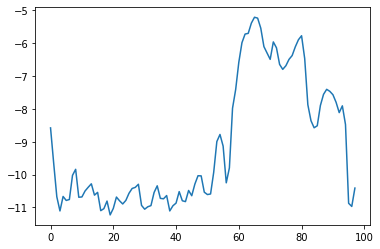

In [164]:
log_att_tot = np.log(atts + 0.00001)

plt.plot(tf.reduce_mean(log_att_tot, axis=0))

Here the model computes a number equal to `num_heads` vectors of attention weights. If avaraged together, they give an idea of where the attention is concentrated.

## Keyword Transformer

In [11]:
kwt = KWT(train_dataset, 
                 num_patches=98,
                 num_layers=2,
                 d_model=192,
                 num_heads=3,
                 mlp_dim=768,
                 output_classes=output_classes)

Input shape: (16000,)


In [12]:
kwt.summary()

Model: "KeyWordTransformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc (MFCC)                  (None, 98, 40, 1)         0         
_________________________________________________________________
removeChannelDimension (Lamb (None, 98, 40)            0         
_________________________________________________________________
dense (Dense)                (None, 98, 192)           7872      
_________________________________________________________________
pos_and_class_embed (PosAndC (None, 99, 192)           19200     
_________________________________________________________________
transformer_block (Transform ((None, 99, 192), (None,  740928    
_________________________________________________________________
transformer_block_1 (Transfo ((None, 99, 192), (

In [13]:
# tf.keras.utils.plot_model(test_model)

In [15]:
kwt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss={'out_layer':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={'out_layer':'accuracy'},
)

early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_accuracy', verbose=1)
history =kwt.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30


2021-08-21 03:42:33.685123: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-21 03:42:33.716298: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz
2021-08-21 03:42:34.192305: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-21 03:42:34.302113: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  1/770 [..............................] - ETA: 43:55 - loss: 2.7269 - accuracy: 0.0781

2021-08-21 03:42:35.330916: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


770/770 [==============================] - 109s 138ms/step - loss: 0.7810 - accuracy: 0.7595 - val_loss: 0.9005 - val_accuracy: 0.7832
Epoch 2/30
770/770 [==============================] - 104s 135ms/step - loss: 0.4855 - accuracy: 0.8437 - val_loss: 0.9151 - val_accuracy: 0.8038
Epoch 3/30
770/770 [==============================] - 108s 140ms/step - loss: 0.4229 - accuracy: 0.8636 - val_loss: 0.5809 - val_accuracy: 0.8455
Epoch 4/30
770/770 [==============================] - 104s 135ms/step - loss: 0.3931 - accuracy: 0.8737 - val_loss: 0.7678 - val_accuracy: 0.8321
Epoch 5/30
770/770 [==============================] - 106s 138ms/step - loss: 0.3596 - accuracy: 0.8847 - val_loss: 0.6464 - val_accuracy: 0.8553
Epoch 6/30
770/770 [==============================] - 108s 141ms/step - loss: 0.3354 - accuracy: 0.8905 - val_loss: 0.8722 - val_accuracy: 0.8420
Epoch 7/30
770/770 [==============================] - 108s 140ms/step - loss: 0.3453 - accuracy: 0.8884 - val_loss: 0.7459 - val_accura